In [1]:
#importing the libraries for dataset
import keras
import pandas as pd
import numpy as np
import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
#Import daily train and test sets (from ARIMA time series models) to use for RRN-LTSM models
WTI_train = pd.read_csv('WTI_train.csv')
WTI_test = pd.read_csv('WTI_test.csv')
BRENT_train = pd.read_csv('BRENT_train.csv')
BRENT_test = pd.read_csv('BRENT_test.csv')

In [3]:
WTI_train['date'] = pd.to_datetime(WTI_train['date'],yearfirst=True)
WTI_test['date'] = pd.to_datetime(WTI_test['date'],yearfirst=True)
BRENT_train['date'] = pd.to_datetime(BRENT_train['date'],yearfirst=True)
BRENT_test['date'] = pd.to_datetime(BRENT_test['date'],yearfirst=True)
WTI_train= WTI_train.rename(columns={"WTI": "WTI_train"})
WTI_test= WTI_test.rename(columns={"WTI": "WTI_test"})
BRENT_train= BRENT_train.rename(columns={"BRENT": "BRENT_train"})
BRENT_test= BRENT_test.rename(columns={"BRENT": "BRENT_test"})
WTI_train.set_index('date')
WTI_train.index = pd.to_datetime(WTI_train['date'],yearfirst=True)
WTI_test.set_index('date')
WTI_test.index = pd.to_datetime(WTI_test['date'],yearfirst=True)
BRENT_train.set_index('date')
BRENT_train.index = pd.to_datetime(BRENT_train['date'],yearfirst=True)
BRENT_test.set_index('date')
BRENT_test.index = pd.to_datetime(BRENT_test['date'],yearfirst=True)

In [4]:
WTI_train_data=WTI_train.iloc[:,1:2].values
WTI_test_data=WTI_test.iloc[:,1:2].values
BRENT_train_data=BRENT_train.iloc[:,1:2].values
BRENT_test_data=BRENT_test.iloc[:,1:2].values

In [5]:
#Scale and normalize the oil price data to (0, 1) values by creating a scalar object.   
scaler=MinMaxScaler(feature_range=(0,1))
WTI_scaled_train_data=scaler.fit_transform(WTI_train_data)
WTI_scaled_test_data=scaler.fit_transform(WTI_test_data)
BRENT_scaled_train_data=scaler.fit_transform(BRENT_train_data)
BRENT_scaled_test_data=scaler.fit_transform(BRENT_test_data)

In [6]:
print(WTI_scaled_train_data.shape, WTI_scaled_test_data.shape, BRENT_scaled_train_data.shape, BRENT_scaled_test_data.shape)

(7218, 1) (351, 1) (7218, 1) (351, 1)


# RNN-LTSM Model for WTI Daily Data

In [7]:
# Create a data structure with 60 lags
WTI_X_train=[]
WTI_y_train=[]
for i in range(60,len(WTI_scaled_train_data)):
    WTI_X_train.append(WTI_scaled_train_data[i-60:i,0])
    WTI_y_train.append(WTI_scaled_train_data[i,0])

#Converting the data to the numpy array as it is expected by our RNN model
WTI_X_train=np.array(WTI_X_train)
WTI_y_train=np.array(WTI_y_train)    

#Reshaping training data to the following format (# values, # time steps, #1 dimensional output)
WTI_X_train=np.reshape(WTI_X_train,(WTI_X_train.shape[0],WTI_X_train.shape[1],1))
print(WTI_X_train.shape)    


(7158, 60, 1)


In [8]:
#Build the LTSM model (LTSM with 50 neurons and 4 hidden layers using the MSE loss function and the Adam stoachastic gradient descent optimizer)
#(See https://medium.com/ai-in-plain-english/time-series-forecasting-predicting-stock-prices-using-an-lstm-model-30d6f1ca2640)

WTI_model=Sequential()

#Adding the first layer and dropout regularization
WTI_model.add(LSTM(units=50,return_sequences=True,input_shape=(WTI_X_train.shape[1],1)))
WTI_model.add(Dropout(0.2))
#Second layer
WTI_model.add(LSTM(units=50,return_sequences=True))
WTI_model.add(Dropout(0.2))
#Third layer
WTI_model.add(LSTM(units=50,return_sequences=True))
WTI_model.add(Dropout(0.2))
#Fourth Layer
WTI_model.add(LSTM(units=50,return_sequences=False))
WTI_model.add(Dropout(0.2))
#Output Layer
WTI_model.add(Dense(units=1))

#Compiling the RNN model
WTI_model.compile(optimizer='adam',loss='mean_squared_error')

#fitting the RNN model on our training dataset
WTI_model.fit(WTI_X_train,WTI_y_train,epochs=100,batch_size=32)



Epoch 1/100
224/224 [==============================] - 34s 150ms/step - loss: 0.0046
Epoch 2/100
224/224 [==============================] - 33s 147ms/step - loss: 0.0018
Epoch 3/100
224/224 [==============================] - 35s 155ms/step - loss: 0.0015
Epoch 4/100
224/224 [==============================] - 38s 171ms/step - loss: 0.0015
Epoch 5/100
224/224 [==============================] - 39s 173ms/step - loss: 0.0012
Epoch 6/100
224/224 [==============================] - 39s 173ms/step - loss: 0.0011
Epoch 7/100
224/224 [==============================] - 39s 172ms/step - loss: 0.0011
Epoch 8/100
224/224 [==============================] - 40s 178ms/step - loss: 9.7907e-04
Epoch 9/100
224/224 [==============================] - 37s 164ms/step - loss: 8.9491e-04
Epoch 10/100
224/224 [==============================] - 37s 166ms/step - loss: 9.0236e-04
Epoch 11/100
224/224 [==============================] - 36s 162ms/step - loss: 8.2597e-04
Epoch 12/100
224/224 [=========================

224/224 [==============================] - 25s 113ms/step - loss: 4.2793e-04
Epoch 93/100
224/224 [==============================] - 26s 114ms/step - loss: 4.4645e-04
Epoch 94/100
224/224 [==============================] - 26s 114ms/step - loss: 4.3594e-04
Epoch 95/100
224/224 [==============================] - 26s 114ms/step - loss: 4.2817e-04
Epoch 96/100
224/224 [==============================] - 25s 113ms/step - loss: 4.4625e-04
Epoch 97/100
224/224 [==============================] - 25s 114ms/step - loss: 4.5038e-04
Epoch 98/100
224/224 [==============================] - 25s 113ms/step - loss: 4.3951e-04
Epoch 99/100
224/224 [==============================] - 26s 118ms/step - loss: 4.6614e-04
Epoch 100/100
224/224 [==============================] - 26s 116ms/step - loss: 4.4525e-04


In [18]:
#Preparing and reshaping test data 
WTI_dataset_total=pd.concat((WTI_train["WTI_train"], WTI_test["WTI_test"]), axis=0)
WTI_inputs = WTI_dataset_total[len(WTI_dataset_total) - len(WTI_test_data) - 60:].values

WTI_inputs = WTI_inputs.reshape(-1,1)
WTI_inputs = scaler.transform(WTI_inputs)
WTI_X_test = []
for i in range(60, len(WTI_scaled_test_data)):
    WTI_X_test.append(WTI_inputs[i-60:i, 0])
    
WTI_X_test = np.array(WTI_X_test)
WTI_X_test = np.reshape(WTI_X_test, (WTI_X_test.shape[0], WTI_X_test.shape[1], 1))
print(WTI_X_test.shape)


(291, 60, 1)


In [19]:
# setting dates for the prediction index
prediction_index= WTI_test["date"].iloc[60:]
prediction_index

date
2019-03-29   2019-03-29
2019-04-01   2019-04-01
2019-04-02   2019-04-02
2019-04-03   2019-04-03
2019-04-04   2019-04-04
                ...    
2020-05-22   2020-05-22
2020-05-26   2020-05-26
2020-05-27   2020-05-27
2020-05-28   2020-05-28
2020-05-29   2020-05-29
Name: date, Length: 291, dtype: datetime64[ns]

In [40]:
#Making predictions using the test data
WTI_predictions=WTI_model.predict(WTI_X_test)
WTI_predictions=scaler.inverse_transform(WTI_predictions)
WTI_predictions = pd.DataFrame(WTI_predictions,index=prediction_index.index)
WTI_predictions

,0
date,
2019-03-29,45.359818
2019-04-01,46.533657
2019-04-02,47.305378
2019-04-03,48.216930
2019-04-04,48.744297
...,...
2020-05-22,51.976173
2020-05-26,50.506824
2020-05-27,49.222134


In [21]:
#Adjusting test data to account for lag of 60 
WTI_test60=WTI_test_data[60:]

In [22]:
#Calculate the model fit and accuracy scores of RNN-LTSM model for predicting WTI test data 
WTI_accuracy = metrics.r2_score(WTI_test60, WTI_predictions)
WTI_MSE = metrics.mean_squared_error(WTI_test60, WTI_predictions)

print(f'the RNN-LTSM Model Fit for predicting WTI oil price data is: R2 = {WTI_accuracy} and MSE = {WTI_MSE}')

the RNN-LTSM Model Fit for predicting WTI oil price data is: R2 = -0.28698904666338376 and MSE = 276.1266017145057


In [59]:
#create shortened time frame for Plotly plot
import datetime
fig_date = pd.datetime(2015,1,1)
WTI_train_2 = WTI_train.loc[WTI_train['date'] >= fig_date]
WTI_train_2

/opt/anaconda2/envs/p36workshop/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



,date,WTI_train
date,,
2015-01-02,2015-01-02,52.72
2015-01-05,2015-01-05,50.05
2015-01-06,2015-01-06,47.98
2015-01-07,2015-01-07,48.69
2015-01-08,2015-01-08,48.80
...,...,...
2018-12-19,2018-12-19,47.96
2018-12-20,2018-12-20,45.64
2018-12-21,2018-12-21,45.38


In [58]:
WTI_predictions.columns = ['WTI_pred']
WTI_train

,date,WTI_train
date,,
1990-01-02,1990-01-02,22.88
1990-01-03,1990-01-03,23.81
1990-01-04,1990-01-04,23.41
1990-01-05,1990-01-05,23.07
1990-01-08,1990-01-08,21.64
...,...,...
2018-12-19,2018-12-19,47.96
2018-12-20,2018-12-20,45.64
2018-12-21,2018-12-21,45.38


In [74]:
#Visualising the predictions and original data using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=WTI_train_2.index,
        y=WTI_train_2["WTI_train"], mode='lines',
        name='WTI Train'))
fig.add_trace(go.Scatter(x=WTI_test.index,
        y=WTI_test["WTI_test"],mode='lines',
        name='"WTI Daily Test'))
fig.add_trace(go.Scatter(x=WTI_predictions.index,
        y=WTI_predictions['WTI_pred'],mode='lines',
        name='"RNN-LTSM WTI Predicted'))
fig.update_layout(
    title= "RNN-LTSM model for WTI Daily Oil Price Over Time: MSE = 276.12",
    xaxis_title="Year",
    yaxis_title="Price($)/Barrel")
fig.show()


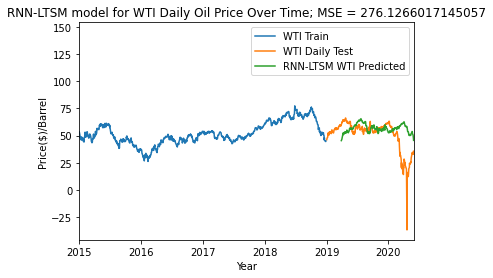

In [75]:
#Visualising the predictions and original data in matplotlib

plt.xlabel('Year')
plt.ylabel('Price($)/Barrel')
plt.plot(WTI_train["WTI_train"],label="WTI Train")
plt.plot(WTI_test["WTI_test"], label = "WTI Daily Test")
plt.plot(WTI_predictions, label = "RNN-LTSM WTI Predicted")
plt.title(f'RNN-LTSM model for WTI Daily Oil Price Over Time; MSE = {WTI_MSE}')
plt.xlim([datetime.date(2015, 1, 1), datetime.date(2020, 6, 1)])
plt.legend()
plt.show()

# RNN-LTSM Model for BRENT Daily Data

In [76]:
# Create a data structure with 60 time-steps and 1 output 
BRENT_X_train=[]
BRENT_y_train=[]
for i in range(60,len(BRENT_scaled_train_data)):
    BRENT_X_train.append(BRENT_scaled_train_data[i-60:i,0])
    BRENT_y_train.append(BRENT_scaled_train_data[i,0])

#Converting the data to the numpy array as it is expected by our RNN model
BRENT_X_train=np.array(BRENT_X_train)
BRENT_y_train=np.array(BRENT_y_train)    

#Reshaping training data to the following format (# values, # time steps, #1 dimensional output)
BRENT_X_train=np.reshape(BRENT_X_train,(BRENT_X_train.shape[0],BRENT_X_train.shape[1],1))
print(BRENT_X_train.shape)

(7158, 60, 1)


In [77]:
#Build the LTSM model (LTSM with 50 neurons and 4 hidden layers using the MSE loss function and the Adam stoachastic gradient descent optimizer)
#(See https://medium.com/ai-in-plain-english/time-series-forecasting-predicting-stock-prices-using-an-lstm-model-30d6f1ca2640)

BRENT_model=Sequential()

#Adding the first layer and dropout regularization
BRENT_model.add(LSTM(units=50,return_sequences=True,input_shape=(BRENT_X_train.shape[1],1)))
BRENT_model.add(Dropout(0.2))
#Second layer
BRENT_model.add(LSTM(units=50,return_sequences=True))
BRENT_model.add(Dropout(0.2))
#Third layer
BRENT_model.add(LSTM(units=50,return_sequences=True))
BRENT_model.add(Dropout(0.2))
#Fourth Layer
BRENT_model.add(LSTM(units=50,return_sequences=False))
BRENT_model.add(Dropout(0.2))
#Output Layer
BRENT_model.add(Dense(units=1))

#Compiling the RNN model
BRENT_model.compile(optimizer='adam',loss='mean_squared_error')

#fitting the RNN model on our training dataset
BRENT_model.fit(BRENT_X_train,BRENT_y_train,epochs=100,batch_size=32)


Epoch 1/100
224/224 [==============================] - 27s 121ms/step - loss: 0.0061
Epoch 2/100
224/224 [==============================] - 28s 126ms/step - loss: 0.0022
Epoch 3/100
224/224 [==============================] - 30s 135ms/step - loss: 0.0020
Epoch 4/100
224/224 [==============================] - 32s 144ms/step - loss: 0.0017
Epoch 5/100
224/224 [==============================] - 32s 141ms/step - loss: 0.0015
Epoch 6/100
224/224 [==============================] - 32s 144ms/step - loss: 0.0014
Epoch 7/100
224/224 [==============================] - 31s 136ms/step - loss: 0.0013
Epoch 8/100
224/224 [==============================] - 34s 153ms/step - loss: 0.0011
Epoch 9/100
224/224 [==============================] - 31s 138ms/step - loss: 0.0011
Epoch 10/100
224/224 [==============================] - 29s 131ms/step - loss: 0.0011
Epoch 11/100
224/224 [==============================] - 34s 154ms/step - loss: 0.0010
Epoch 12/100
224/224 [==============================] - 33s 148

224/224 [==============================] - 30s 135ms/step - loss: 5.1255e-04
Epoch 93/100
224/224 [==============================] - 27s 123ms/step - loss: 5.3960e-04
Epoch 94/100
224/224 [==============================] - 32s 144ms/step - loss: 5.0794e-04
Epoch 95/100
224/224 [==============================] - 33s 146ms/step - loss: 5.2275e-04
Epoch 96/100
224/224 [==============================] - 30s 136ms/step - loss: 5.0751e-04
Epoch 97/100
224/224 [==============================] - 35s 157ms/step - loss: 5.2929e-04
Epoch 98/100
224/224 [==============================] - 33s 149ms/step - loss: 5.4414e-04
Epoch 99/100
224/224 [==============================] - 30s 133ms/step - loss: 5.3369e-04
Epoch 100/100
224/224 [==============================] - 27s 122ms/step - loss: 5.2303e-04


In [84]:
#Preparing and reshaping test data 
BRENT_dataset_total=pd.concat((BRENT_train["BRENT_train"], BRENT_test["BRENT_test"]), axis=0)
BRENT_inputs = BRENT_dataset_total[len(BRENT_dataset_total) - len(BRENT_test_data) - 60:].values

BRENT_inputs = BRENT_inputs.reshape(-1,1)
BRENT_inputs = scaler.transform(BRENT_inputs)
BRENT_X_test = []
for i in range(60, len(BRENT_scaled_test_data)):
    BRENT_X_test.append(BRENT_inputs[i-60:i, 0])
BRENT_X_test = np.array(BRENT_X_test)
BRENT_X_test = np.reshape(BRENT_X_test, (BRENT_X_test.shape[0], BRENT_X_test.shape[1], 1))
print(BRENT_X_test.shape)

(291, 60, 1)


In [85]:
#setting prediction index
prediction_index= BRENT_test["date"].iloc[60:]
prediction_index

date
2019-03-29   2019-03-29
2019-04-01   2019-04-01
2019-04-02   2019-04-02
2019-04-03   2019-04-03
2019-04-04   2019-04-04
                ...    
2020-05-22   2020-05-22
2020-05-26   2020-05-26
2020-05-27   2020-05-27
2020-05-28   2020-05-28
2020-05-29   2020-05-29
Name: date, Length: 291, dtype: datetime64[ns]

In [86]:
#Making predictions using the test data
BRENT_predictions=BRENT_model.predict(BRENT_X_test)
BRENT_predictions=scaler.inverse_transform(BRENT_predictions)
BRENT_predictions = pd.DataFrame(BRENT_predictions,index=prediction_index.index)
BRENT_predictions

,0
date,
2019-03-29,50.457275
2019-04-01,53.266285
2019-04-02,53.428158
2019-04-03,55.192379
2019-04-04,57.296432
...,...
2020-05-22,57.231930
2020-05-26,55.760094
2020-05-27,55.084091


In [87]:
#Adjusting test data for lag of 60
BRENT_test60=BRENT_test_data[60:]

In [88]:
#Calculate the model fit and accuracy scores of RNN-LTSM model for predicting BRENT test data 
BRENT_accuracy = metrics.r2_score(BRENT_test60, BRENT_predictions)
BRENT_MSE = metrics.mean_squared_error(BRENT_test60, BRENT_predictions)

In [89]:
#create shortened time frame for Plotly plot
import datetime
fig_date = pd.datetime(2015,1,1)
BRENT_train_2 = BRENT_train.loc[BRENT_train['date'] >= fig_date]
BRENT_train_2

/opt/anaconda2/envs/p36workshop/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



,date,BRENT_train
date,,
2015-01-02,2015-01-02,55.38
2015-01-05,2015-01-05,51.08
2015-01-06,2015-01-06,50.12
2015-01-07,2015-01-07,49.06
2015-01-08,2015-01-08,49.43
...,...,...
2018-12-19,2018-12-19,55.60
2018-12-20,2018-12-20,52.84
2018-12-21,2018-12-21,51.93


In [91]:
BRENT_predictions.columns = ['BRENT_pred']

In [92]:
#Visualising the predictions and original data using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=BRENT_train_2.index,
        y=BRENT_train_2["BRENT_train"], mode='lines',
        name='BRENT Train'))
fig.add_trace(go.Scatter(x=BRENT_test.index,
        y=BRENT_test["BRENT_test"],mode='lines',
        name='"BRENT Daily Test'))
fig.add_trace(go.Scatter(x=BRENT_predictions.index,
        y=BRENT_predictions['BRENT_pred'],mode='lines',
        name='"RNN-LTSM WTI Predicted'))
fig.update_layout(
    title= "RNN-LTSM model for BRENT Daily Oil Price Over Time: MSE = 276.12",
    xaxis_title="Year",
    yaxis_title="Price($)/Barrel")
fig.show()

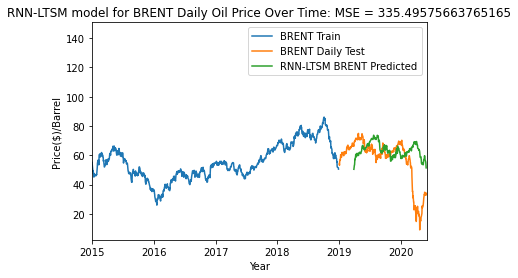

In [93]:
#Visualising the predictions and original data in Matplotlib
plt.xlabel('Year')
plt.ylabel('Price($)/Barrel')
plt.plot(BRENT_train["BRENT_train"],label="BRENT Train")
plt.plot(BRENT_test["BRENT_test"], label = "BRENT Daily Test")
plt.plot(BRENT_predictions, label = "RNN-LTSM BRENT Predicted")
plt.title(f'RNN-LTSM model for BRENT Daily Oil Price Over Time: MSE = {BRENT_MSE}')
plt.xlim([datetime.date(2015, 1, 1), datetime.date(2020, 6, 1)])
plt.legend()
plt.show()